In [1]:
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np

In [405]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [406]:
# Y_true

### Data

In [3]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [4]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [5]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [6]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [7]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [8]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [9]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [10]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [11]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [12]:
# Initializing parameters
epochs = 30
batch_size = 16
n_hidden = 32

In [13]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [14]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

D:\Installation\Anaconda\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':
D:\Installation\Anaconda\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [15]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [91]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [23]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 92s 13ms/step - loss: 1.3018 - acc: 0.4395 - val_loss: 1.1254 - val_acc: 0.4662
Epoch 2/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.9666 - acc: 0.5880 - val_loss: 0.9491 - val_acc: 0.5714
Epoch 3/30
7352/7352 [==============================] - 97s 13ms/step - loss: 0.7812 - acc: 0.6408 - val_loss: 0.8286 - val_acc: 0.5850
Epoch 4/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.6941 - acc: 0.6574 - val_loss: 0.7297 - val_acc: 0.6128
Epoch 5/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.6336 - acc: 0.6912 - val_loss: 0.7359 - val_acc: 0.6787
Epoch 6/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.5859 - acc: 0.7134 - val_loss: 0.7015 - val_acc: 0.6939
Epoch 7/30
7352/7352 [==============================] - 95s 13ms/step - loss: 0.5692 - acc: 0.7477 - val_loss: 0.5995 - val_acc: 0.7387


In [24]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [27]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [28]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

### Creating the first class classifier

In [18]:
X_train[0]

array([[ 1.808515e-04,  1.076681e-02,  5.556068e-02, ...,  1.012817e+00,
        -1.232167e-01,  1.029341e-01],
       [ 1.013856e-02,  6.579480e-03,  5.512483e-02, ...,  1.022833e+00,
        -1.268756e-01,  1.056872e-01],
       [ 9.275574e-03,  8.928878e-03,  4.840473e-02, ...,  1.022028e+00,
        -1.240037e-01,  1.021025e-01],
       ...,
       [-1.147484e-03,  1.714439e-04,  2.647864e-03, ...,  1.018445e+00,
        -1.240696e-01,  1.003852e-01],
       [-2.222655e-04,  1.574181e-03,  2.381057e-03, ...,  1.019372e+00,
        -1.227451e-01,  9.987355e-02],
       [ 1.575500e-03,  3.070189e-03, -2.269757e-03, ...,  1.021171e+00,
        -1.213260e-01,  9.498741e-02]])

In [39]:
X_train.shape

(7352, 128, 9)

In [46]:
# from sklearn.ensemble import RandomForestClassifier
# # estimator_arr_param = [100, 200, 250, 300]
# # depth_arr_param = [2, 5, 10]
# clf = RandomForestClassifier(n_estimators=100, max_depth=3, criterion='gini')
    
# clf.fit(X_train, Y_train)
# y_train_pred = batch_predict(clf, X_train)
# y_test_pred = batch_predict(clf, X_test)

In [30]:
print(len(X_train))
print(len(X_train[0]))
print(len(X_train[0][0]))

7352
128
9


In [24]:
len(Y_train)

7352

In [29]:
len(X_train.shape)

3

In [57]:
print(len(X_train[0]))
print(len(X_train[0][0]))
# print(len(X_train[0][0][0]))
print(X_train.shape)
print("*"*10)
print(timesteps)
print(input_dim)

128
9
(7352, 128, 9)
**********
128
9


In [225]:
Y_train

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]], dtype=uint8)

In [226]:
Y_train_new_d

[array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([1, 0, 0], dtype=uint8),
 array([

In [201]:
# Initiliazing the sequential model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
model = Sequential()

model.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
model.add(Dropout(0.3))
model.add(Flatten())

model.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model.add(Dense(6, activation='softmax', name="dense_1"))
print(model.summary())

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model
model.fit(X_train_new,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test_new, Y_test),
          epochs=15)

loss = model.evaluate(X_test_new,
          Y_test)
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_28 (Dropout)         (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 169350    
Total params: 282,566
Trainable params: 226,118
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] -

Checking the accuracy of the model where it is lagging.

In [202]:

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

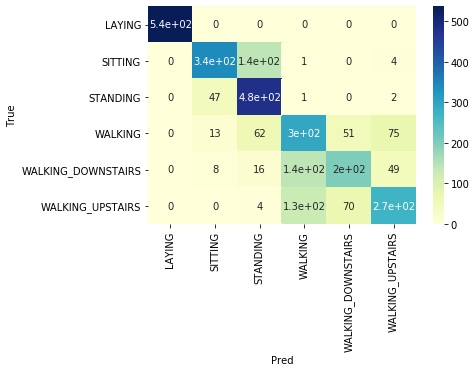

In [208]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(confusion_matrix(Y_test, model.predict(X_test_new)), annot=True, cmap="YlGnBu")
plt.show()
# print(confusion_matrix(Y_test, model.predict(X_test_new)))

##### confusion arose in between: laying sitting standing
##### confusion arose in between: walking walkupstairs, walkdownstairs


# 2 stage classification

## Binary Class classifier

Dynamic: Walk, Walk Upstairs, Walk Downstairs <br>
Static: Stand, Sit, Lay

where we can pick Y's calsses

    1. Walking     
    2. WalkingUpstairs 
    3. WalkingDownstairs 
    4. Standing 
    5. Sitting 
    6. Lying.


In [120]:
from numpy import newaxis
X_train_new = X_train[:,:,:, newaxis]
print(X_train_new.shape)
X_test_new = X_test[:,:,:, newaxis]
print(X_test_new.shape)

(7352, 128, 9, 1)
(2947, 128, 9, 1)


In [131]:
Y_binary_train=[]
Y_binary_test=[]

for arr in Y_train:
    #     print(val, end="|")
    if arr[0] ==1 or arr[1]==1 or arr[2]==1:
        Y_binary_train.append(1)
    else:
        Y_binary_train.append(0)
        
for arr in Y_test:
    #     print(val, end="|")
    if arr[0] ==1 or arr[1]==1 or arr[2]==1:
        Y_binary_test.append(1)
    else:
        Y_binary_test.append(0)
        

print(len(Y_binary_train))
print(len(Y_binary_test))


7352
2947


In [210]:
# Initiliazing the sequential binary_model_1
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dense, Dropout, Flatten
binary_model_1 = Sequential()

binary_model_1.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# Adding a dropout layer
binary_model_1.add(Dropout(0.3))
binary_model_1.add(Flatten())

binary_model_1.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
binary_model_1.add(Dense(1, activation='sigmoid', name="dense_1"))
print(binary_model_1.summary())

# Compiling the binary_model_1
binary_model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the binary_model_1
binary_model_1.fit(X_train_new,
          Y_binary_train,
          batch_size=batch_size,
          validation_data=(X_test_new, Y_binary_test),
          epochs=15)

loss = binary_model_1.evaluate(X_test_new,
          Y_binary_test)
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_29 (Dropout)         (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 28225     
Total params: 141,441
Trainable params: 84,993
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 7352 samples, validate on 2947 samples
Epoch 1/15
7352/7352 [==============================] - 

In [388]:
y_hat_binary = binary_model_1.predict_classes(X_test_new)
# ans = [1 if ele[0]>=0.1 else 0 for ele in y_hat_binary]
# ans

In [390]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_binary_test, y_hat_binary))
len(y_hat_binary)

[[1556    4]
 [   1 1386]]


2947

In [213]:
arr = [1,2,3,4,5,6]
arr1 = arr[:3]
arr2=arr[3:]
print(arr1)
print(arr2)


[1, 2, 3]
[4, 5, 6]


In [214]:
for arr in Y_train:
    Y_train_d=  arr[:3]
    Y_train_s=  arr[3:]
    

In [215]:
print(X_train_new.shape)
print(X_test_new.shape)
print(Y_train.shape)
print(Y_test.shape)

(7352, 128, 9, 1)
(2947, 128, 9, 1)
(7352, 6)
(2947, 6)


### Taking help of predicted value from model1 to divide it into static and dynamic data

In [399]:
y_hat_binary

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [396]:
y_hat_binary[0][0]

0

In [ ]:
for val in 

In [414]:
X_train_new_d = []
Y_train_new_d = []
X_train_new_s = []
Y_train_new_s = []

for ind, val in enumerate(y_hat_binary): #<------------- we are using ans to divide the data
    if val[0] == 1:
        X_train_new_d.append(X_train_new[ind])
        Y_train_new_d.append(list(Y_train[ind][:3]))
#         print(Y_train[ind], "||d||strt3|||", Y_train[ind][:3])
        if max(Y_train[ind][:3])==0: print("Misclassified")
    else:
        X_train_new_s.append(X_train_new[ind])
        Y_train_new_s.append(list(Y_train[ind][3:]))
#         print(Y_train[ind], "||s||end 3|||", Y_train[ind][3:])
        if max(Y_train[ind][3:])==0: print("Misclassified")

X_test_new_d = []
Y_test_new_d = []
X_test_new_s = []
Y_test_new_s = []

for ind, val in enumerate(y_hat_binary):
    if val[0] == 1:
        X_test_new_d.append(X_test_new[ind])
        Y_test_new_d.append(list(Y_test[ind][:3]))
    else:
        X_test_new_s.append(X_test_new[ind])
        Y_test_new_s.append(list(Y_test[ind][3:]))
        

Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Miscla

Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Miscla

Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Misclassified
Miscla

In [408]:
print(len(X_train_new_d))
print(len(Y_train_new_d))
print("*"*20)
print(len(X_train_new_s))
print(len(Y_train_new_s))
print("*"*20)
print(len(X_test_new_d))
print(len(Y_test_new_d))
print("*"*20)
print(len(X_test_new_s))
print(len(Y_test_new_s))
print("*"*20)

1390
1390
********************
1557
1557
********************
1390
1390
********************
1557
1557
********************


In [234]:
# X_train_new_d

### Model for dynamic

In [229]:
Y_test_new_d

[[1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 0, 1],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [0, 1, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1, 0, 0],
 [1,

In [242]:
X_train_new_d[0][0][0][0]

0.3767984

In [243]:
X_train.shape

(7352, 128, 9)

In [245]:
type(np.array(X_train_new_d))

numpy.ndarray

In [246]:
np.array(X_train_new_d).shape

(3285, 128, 9, 1)

In [263]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='softmax', name="dense_1"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=15)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 16)        160       
_________________________________________________________________
dropout_47 (Dropout)         (None, 126, 7, 16)        0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 126, 7, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 42, 2, 16)         0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dropout_48 (Dropout)         (None, 1344)              0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 1344)            

In [269]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=15)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 16)        416       
_________________________________________________________________
dropout_55 (Dropout)         (None, 124, 5, 16)        0         
_________________________________________________________________
batch_normalization_44 (Batc (None, 124, 5, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 41, 1, 16)         0         
_________________________________________________________________
flatten_38 (Flatten)         (None, 656)               0         
_________________________________________________________________
dropout_56 (Dropout)         (None, 656)               0         
_________________________________________________________________
batch_normalization_45 (Batc (None, 656)             

In [270]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 16)        416       
_________________________________________________________________
dropout_57 (Dropout)         (None, 124, 5, 16)        0         
_________________________________________________________________
batch_normalization_46 (Batc (None, 124, 5, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 41, 1, 16)         0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 656)               0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 656)               0         
_________________________________________________________________
batch_normalization_47 (Batc (None, 656)             

In [271]:
from keras.layers import MaxPooling1D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 16)        160       
_________________________________________________________________
dropout_59 (Dropout)         (None, 126, 7, 16)        0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 126, 7, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 42, 2, 16)         0         
_________________________________________________________________
flatten_40 (Flatten)         (None, 1344)              0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 1344)              0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 1344)            

In [290]:
def plt_dynamic(x,vy,ty,ax,color=['b']):
  ax.plot(x,vy,'b',label='validation accuracy')
  ax.plot(x,ty,'r',label='Train accuracy')
  plt.legend()
  plt.grid()
  fig.canvas.draw()

In [272]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.5))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(3, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_61 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_50 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_41 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_62 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_51 (Batc (None, 640)             

In [278]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0914 16:25:42.424170 12496 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_69 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_58 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_43 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_59 (Batc (None, 640)             

In [279]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.7))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(3, activation='softmax', name="dense_2"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0914 16:30:15.172947 12496 nn_ops.py:4224] Large dropout rate: 0.7 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_90"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_71 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_44 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_72 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 640)             

In [280]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(16, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(32, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0914 16:36:25.765567 12496 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_91"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 16)        800       
_________________________________________________________________
dropout_73 (Dropout)         (None, 122, 3, 16)        0         
_________________________________________________________________
batch_normalization_62 (Batc (None, 122, 3, 16)        64        
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 16)         0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 640)               0         
_________________________________________________________________
dropout_74 (Dropout)         (None, 640)               0         
_________________________________________________________________
batch_normalization_63 (Batc (None, 640)             

In [281]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.5))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

W0914 16:42:21.066452 12496 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_75 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_76 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 1280)            

In [282]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.7))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.7))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_77 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_66 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_78 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_67 (Batc (None, 1280)            

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_79 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_68 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_48 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_69 (Batc (None, 1280)            

NameError: name 'history' is not defined

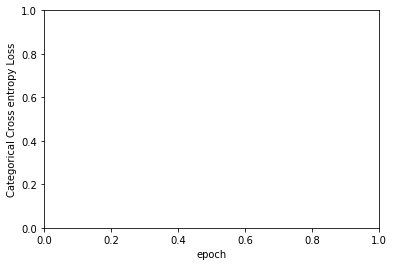

In [283]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.6))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.6))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epochs+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_81 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_49 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_82 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 1280)            

NameError: name 'plt_dynamic' is not defined

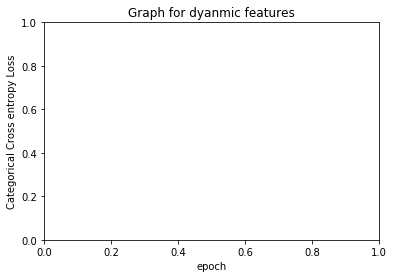

In [284]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.7))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.7))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epochs+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_96"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_83 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_50 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 1280)            

ValueError: x and y must have same first dimension, but have shapes (30,) and (35,)

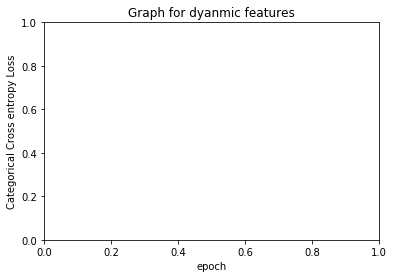

In [286]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.4))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.6))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

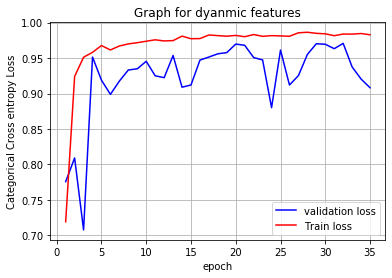

In [289]:

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_97"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_85 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_74 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_51 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_86 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_75 (Batc (None, 1280)            

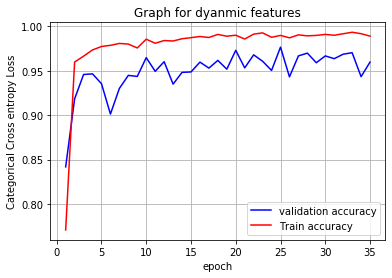

In [291]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.4))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.4))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_98"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_87 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_76 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_52 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_88 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_77 (Batc (None, 1280)            

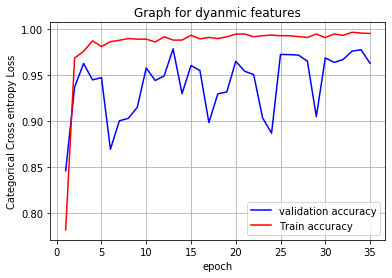

In [292]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.3))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.3))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_89 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_90 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 1280)            

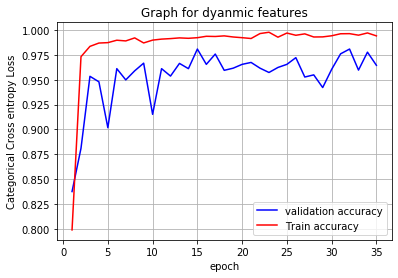

In [293]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2d.add(Dropout(0.2))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

model_2d.add(Dropout(0.2))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_100"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_80 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
dense_2 (Dense)              (None, 64)             

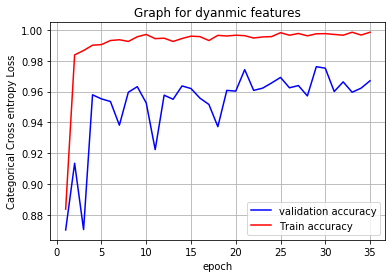

In [294]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2d.add(Dropout(0.2))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

# model_2d.add(Dropout(0.2))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(32, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(64, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_101"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_82 (Batc (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_55 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_83 (Batc (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_2 (Dense)              (None, 32)             

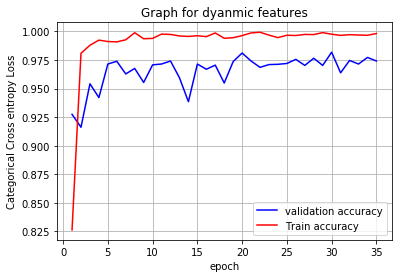

In [295]:
from keras.layers import MaxPooling2D
model_2d = Sequential()

model_2d.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2d.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2d.add(Dropout(0.2))

model_2d.add(BatchNormalization())
model_2d.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2d.add(Flatten())

# model_2d.add(Dropout(0.2))
model_2d.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2d.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2d.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2d.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2d.summary())

# Compiling the model_2d
model_2d.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2d
history = model_2d.fit(np.array(X_train_new_d),
          np.array(Y_train_new_d),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_d), np.array(Y_test_new_d)),
          epochs=35)

loss = model_2d.evaluate(np.array(X_test_new_d), np.array(Y_test_new_d))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

## We will continue with this model as it is giving accuracy more than 97%

### Hyperparameter tune with static models

In [252]:
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(3, activation='softmax', name="dense_1"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=15)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
dropout_37 (Dropout)         (None, 126, 7, 32)        0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 84675     
Total params: 197,891
Trainable params: 141,443
Non-trainable params: 56,448
_________________________________________________________________
None
Train on 4067 samples, validate on 1560 samples
Epoch 1/15
4067/4067 [==============================] -

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 124, 5, 32)        9248      
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 122, 3, 32)        9248      
_________________________________________________________________
dropout_94 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
flatten_59 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_87 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 16)             

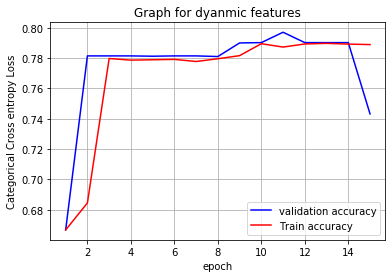

In [302]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer2",
                activation='sigmoid'))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer3",
                activation='sigmoid'))
# Adding a dropout layer
model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 124, 5, 32)        9248      
_________________________________________________________________
conv_layer3 (Conv2D)         (None, 122, 3, 32)        9248      
_________________________________________________________________
flatten_60 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_88 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                187408    
_________________________________________________________________
dense_2 (Dense)              (None, 32)             

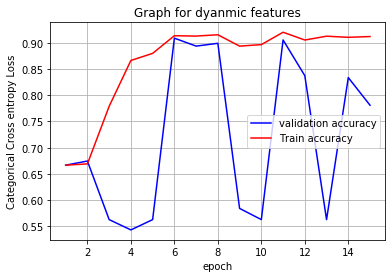

In [303]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer2",
                activation='sigmoid'))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer3",
                activation='sigmoid'))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
conv_layer2 (Conv2D)         (None, 124, 5, 32)        9248      
_________________________________________________________________
flatten_61 (Flatten)         (None, 19840)             0         
_________________________________________________________________
batch_normalization_89 (Batc (None, 19840)             79360     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                317456    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)              

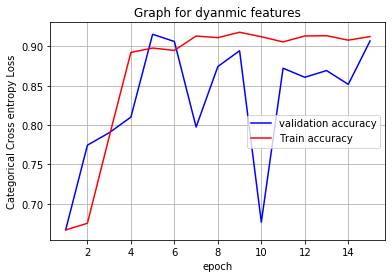

In [304]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer2",
                activation='sigmoid'))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
flatten_62 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                451600    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 565,459
Trainable params: 509,011
Non-trainable params: 56,448
_________________________________________

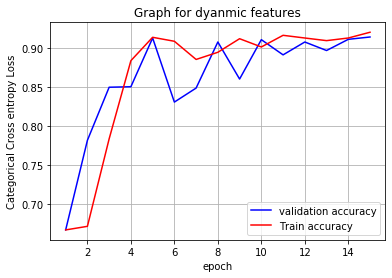

In [305]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='softmax', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='softmax', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
flatten_63 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 16)                451600    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 565,459
Trainable params: 509,011
Non-trainable params: 56,448
_________________________________________

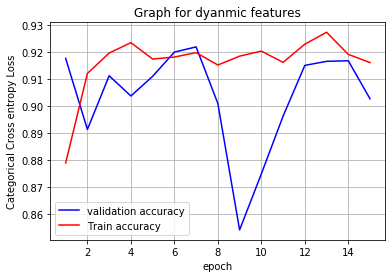

In [306]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_113"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 126, 7, 32)        320       
_________________________________________________________________
flatten_64 (Flatten)         (None, 28224)             0         
_________________________________________________________________
batch_normalization_92 (Batc (None, 28224)             112896    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                903200    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 1,017,571
Trainable params: 961,123
Non-trainable params: 56,448
_______________________________________

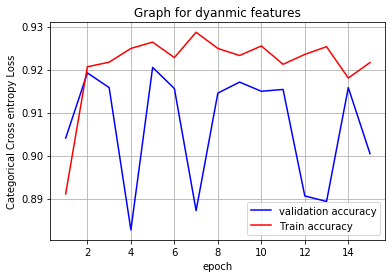

In [307]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (3, 3), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_114"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 124, 5, 32)        832       
_________________________________________________________________
flatten_65 (Flatten)         (None, 19840)             0         
_________________________________________________________________
batch_normalization_93 (Batc (None, 19840)             79360     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                634912    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 716,259
Trainable params: 676,579
Non-trainable params: 39,680
_________________________________________

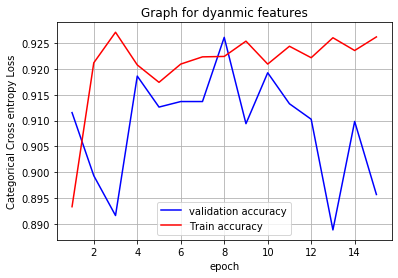

In [308]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (5, 5), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_115"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
flatten_66 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                374816    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 424,419
Trainable params: 400,995
Non-trainable params: 23,424
_________________________________________

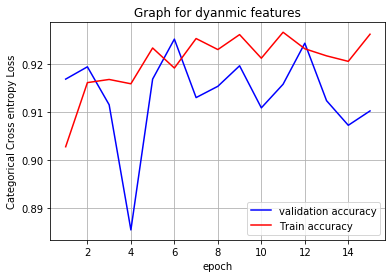

In [309]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_116"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
flatten_67 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                374816    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 424,419
Trainable params: 400,995
Non-trainable params: 23,424
_________________________________________

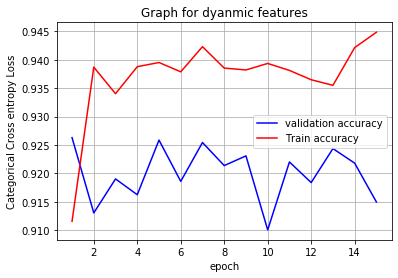

In [310]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_118"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
flatten_69 (Flatten)         (None, 11712)             0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 11712)             46848     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                374816    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 424,419
Trainable params: 400,995
Non-trainable params: 23,424
_________________________________________

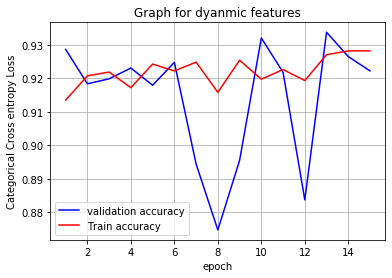

In [312]:
epoch_ = 15
model_2s = Sequential()

model_2s.add(Conv2D(n_hidden, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='sigmoid', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(n_hidden, 
#                 kernel_size = (3, 3), name="conv_layer1",
#                 activation='sigmoid', input_shape=(128, 9, 1)))
# Adding a dropout layer
# model_2s.add(Dropout(0.3))
model_2s.add(Flatten())

model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
# print(model_2s.summary())
model_2s.add(Dense(32, activation='relu', name="dense_2"))
# print(model_2s.summary())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))
print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=epoch_)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, epoch_+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)



Model: "sequential_122"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_104 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_73 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                20496     
_________________________________________________________________
dense_2 (Dense)              (None, 32)             

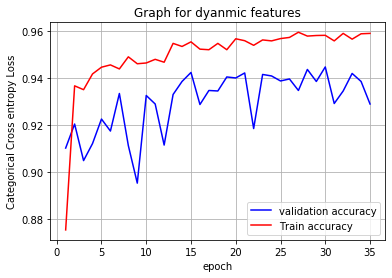

In [317]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(16, activation='sigmoid', name="dense_1"))
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

### Adding batch normalization in all different steps

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_108 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_75 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_109 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_110 (Bat (None, 32)             

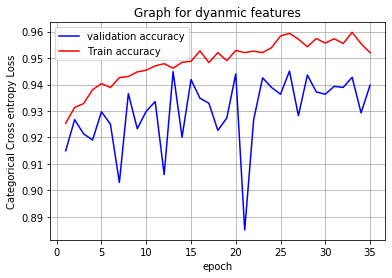

In [319]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='sigmoid', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_125"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_112 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_76 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_114 (Bat (None, 32)             

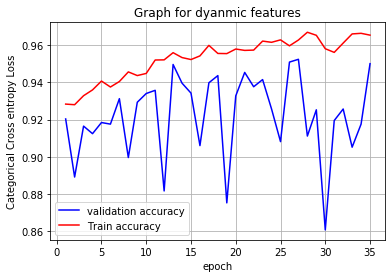

In [320]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='sigmoid', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_126"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_116 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_77 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_117 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_118 (Bat (None, 32)             

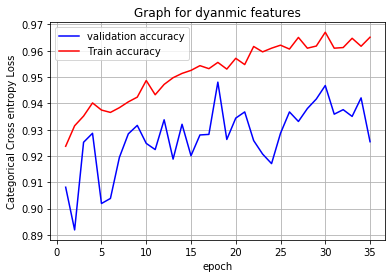

In [321]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='relu', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_127"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_120 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_78 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_121 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                40992     
_________________________________________________________________
batch_normalization_122 (Bat (None, 32)             

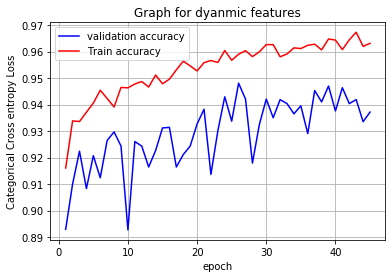

In [322]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(32, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(32, activation='relu', name="dense_2"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=45)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 45+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_129"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_127 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_80 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_128 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                61488     
_________________________________________________________________
batch_normalization_129 (Bat (None, 48)             

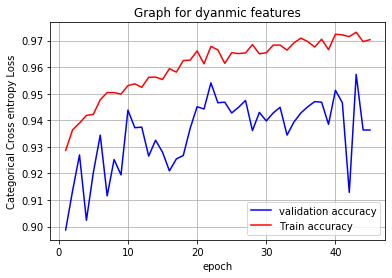

In [324]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=45)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 45+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_130"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_130 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_81 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_95 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_131 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)             

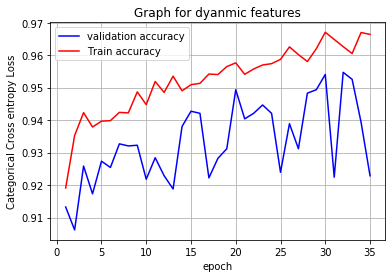

In [325]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_131"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_96 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_133 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_82 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_97 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_134 (Bat (None, 1280)           

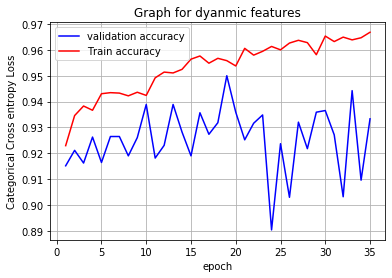

In [326]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_132"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
dropout_98 (Dropout)         (None, 122, 3, 32)        0         
_________________________________________________________________
batch_normalization_136 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_83 (Flatten)         (None, 1280)              0         
_________________________________________________________________
dropout_99 (Dropout)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_137 (Bat (None, 1280)           

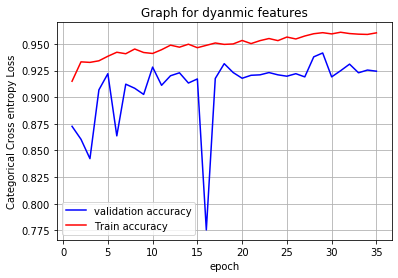

In [327]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
model_2s.add(Dropout(0.3))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

model_2s.add(Dropout(0.3))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=35)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 35+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

Model: "sequential_133"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_layer1 (Conv2D)         (None, 122, 3, 32)        1600      
_________________________________________________________________
batch_normalization_139 (Bat (None, 122, 3, 32)        128       
_________________________________________________________________
max_pooling_layer (MaxPoolin (None, 40, 1, 32)         0         
_________________________________________________________________
flatten_84 (Flatten)         (None, 1280)              0         
_________________________________________________________________
batch_normalization_140 (Bat (None, 1280)              5120      
_________________________________________________________________
dense_1 (Dense)              (None, 48)                61488     
_________________________________________________________________
batch_normalization_141 (Bat (None, 48)             

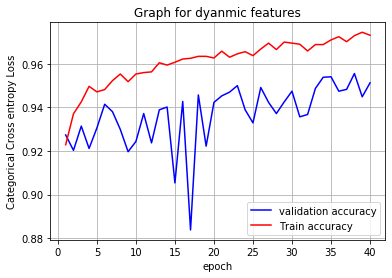

In [328]:
from keras.layers import MaxPooling2D
model_2s = Sequential()

model_2s.add(Conv2D(32, 
                kernel_size = (7, 7), name="conv_layer1",
                activation='relu', input_shape=(128, 9, 1)))
# model_2s.add(Conv2D(32, 
#                 kernel_size = (5, 5), name="conv_layer2",
#                 activation='relu'))
# Adding a dropout layer
# model_2s.add(Dropout(0.2))

model_2s.add(BatchNormalization())
model_2s.add(MaxPooling2D(pool_size=3, strides=None, name="max_pooling_layer"))
model_2s.add(Flatten())

# model_2s.add(Dropout(0.2))
model_2s.add(BatchNormalization())

# Adding a dense output layer with sigmoid activation
model_2s.add(Dense(48, activation='relu', name="dense_1"))
model_2s.add(BatchNormalization())
model_2s.add(Dense(48, activation='relu', name="dense_2"))
# model_2s.add(BatchNormalization())
model_2s.add(Dense(3, activation='softmax', name="dense_3"))


print(model_2s.summary())

# Compiling the model_2s
model_2s.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
			  
			  
# Training the model_2s
history = model_2s.fit(np.array(X_train_new_s),
          np.array(Y_train_new_s),
          batch_size=batch_size,
          validation_data=(np.array(X_test_new_s), np.array(Y_test_new_s)),
          epochs=40)

loss = model_2s.evaluate(np.array(X_test_new_s), np.array(Y_test_new_s))
print("loss: ", loss[0])
print("Accuracy", loss[1])

fig, ax = plt.subplots(1, 1)
ax.set_xlabel('epoch')
ax.set_ylabel('Categorical Cross entropy Loss')

x = list(range(1, 40+1))

vy = history.history['val_acc']
ty = history.history['acc']
plt.title("Graph for dyanmic features")
plt_dynamic(x, vy, ty, ax)

### Keeping this model as final model.

## Now combining both the model to predict the values.

In [ ]:
# X_train_new_d = []
# Y_train_new_d = []
# X_train_new_s = []
# Y_train_new_s = []

# for ind, val in enumerate(ans): #<------------- we are using ans to divide the data
#     if val is 1:
#         X_train_new_d.append(X_train_new[ind])
#         Y_train_new_d.append(list(Y_train[ind][:3]))
        
#     else:
#         X_train_new_s.append(X_train_new[ind])
#         Y_train_new_s.append(list(Y_train[ind][3:]))

# X_test_new_d = []
# Y_test_new_d = []
# X_test_new_s = []
# Y_test_new_s = []

# for ind, val in enumerate(ans):
#     if val is 1:
#         X_test_new_d.append(X_test_new[ind])
#         Y_test_new_d.append(list(Y_test[ind][:3]))
#     else:
#         X_test_new_s.append(X_test_new[ind])
#         Y_test_new_s.append(list(Y_test[ind][3:]))

        

In [330]:
ap = [0, 0, 0]
ap.extend([1,2,3])
ap

[0, 0, 0, 1, 2, 3]

In [337]:
Y_train_orignal = []
Y_hat_train_orignal = []
for ind, arr in enumerate(Y_train_new_d):
    Y_train_orignal.append([0, 0, 0].extend(arr))
# Y_hat_train_orignal.append(extend())
Y_hat_train_orignal = model_2d.predict(np.array(X_train_new_d))
# Y_hat_train_orignal = [[0, 0, 0].extend(val) for val in Y_hat_train_orignal]
    
# for ind, arr in enumerate(Y_train_new_s):
#     Y_train_orignal.append(arr.extend([0, 0, 0]))
#     Y_hat_train_orignal.append(model_2s.predict(np.array(X_train_new_s[ind])).extend([0, 0, 0]))
    
# Y_test_orignal = []
# Y_hat_test_orignal = []
# for arr in enumerate(Y_test_new_d):
#     Y_test_orignal.append([0, 0, 0].extend(arr))
#     Y_hat_test_orignal.append([0, 0, 0].extend(model_2d.predict(np.array(X_test_new_d[ind]))))
    
# for arr in enumerate(Y_test_new_s):
#     Y_test_orignal.append(arr.extend([0, 0, 0]))
#     Y_hat_test_orignal.append(model_2s.predict(np.array(X_test_new_s[ind])).extend([0, 0, 0]))
    

In [351]:
# ok = [0, 0, 0].extend([2,1,2])
# print(ok)

None


In [382]:
import pickle
filename= "model_2d.pickle"
outfile = open(filename,'wb')
pickle.dump(model_2d,outfile)
outfile.close()

filename= "model_2s.pickle"
outfile = open(filename,'wb')
pickle.dump(model_2s,outfile)
outfile.close()

#### Below blocks are inplace which will modify existing data please execute it once, i.e.:Y_train_new_d, Y_train_new_s

In [409]:
#Creating dynamic features train data
y_hat_train=[]
y_n_train=[]
val = model_2d.predict_classes(np.array(X_train_new_d))
for v in val:
    if v is 0:
        arr = [1, 0, 0]
    elif v is 1:
        arr = [0, 1, 0]
    else:
        arr = [0, 0, 1]
    arr = arr.extend([0, 0, 0])
    y_hat_train.append(arr)
# y_n_train.extend(Y_train_new_d)
for v in Y_train_new_d:
    v.extend([0,0,0])
#     y_n_train.append(v)

#appending static features train data   
val = model_2d.predict_classes(np.array(X_train_new_s))
for v in val:
    if v is 0:
        arr = [1, 0, 0]
    elif v is 1:
        arr = [0, 1, 0]
    else:
        arr = [0, 0, 1]
    temp=[0,0,0]
    temp.extend(arr)
    y_hat_train.append(temp)
for v in Y_train_new_s:
    [0, 0, 0].extend(v)
#     y_n_train.append(v)


        

In [410]:
#Creating dynamic features test data
y_hat_test=[]
y_n_test=[]
val = model_2d.predict_classes(np.array(X_test_new_d))
for v in val:
    if v is 0:
        arr = [1, 0, 0]
    elif v is 1:
        arr = [0, 1, 0]
    else:
        arr = [0, 0, 1]
    arr.extend([0, 0, 0])
    y_hat_test.append(arr)
# y_n_test.extend(Y_test_new_d)
for v in Y_test_new_d:
    v.extend([0,0,0])
#     y_n_test.append(v)

#appending static features test data   
val = model_2d.predict_classes(np.array(X_test_new_s))
for v in val:
    if v is 0:
        arr = [1, 0, 0]
    elif v is 1:
        arr = [0, 1, 0]
    else:
        arr = [0, 0, 1]
    temp = [0, 0, 0]
    temp.extend(arr)
    y_hat_test.append(temp)
for v in Y_test_new_s:
    [0, 0, 0].extend(v)
#     y_n_test.append(v)


        

In [372]:
Y_train_new = []
Y_train_new.extend(Y_train_new_d)
Y_train_new.extend(Y_train_new_s)

Y_test_new = []
Y_test_new.extend(Y_test_new_d)
Y_test_new.extend(Y_test_new_s)



## Confusion matrix for train data

In [377]:
# from sklearn.metrics import confusion_matrix
# print(confusion_matrix(Y_train_new, y_hat_train))

In [379]:
def getvalue(arr):
    if arr[0] is 1:
        return 1
    elif arr[1] is 1:
        return 2
    elif arr[2] is 1:
        return 3
    elif arr[3] is 1:
        return 4
    elif arr[4] is 1:
        return 5
    elif arr[5] is 1:
        return 6
    
    

In [383]:
# Y_train_mc = []
# for val in Y_train_new:
#     print(val)
#     Y_train_mc.append(getvalue(val))

# Y_test_mc = []
# for val in Y_test_new:
#     Y_test_mc.append(getvalue(val))
    
# y_hat_train_mc = []
# for val in y_hat_train:
#     y_hat_train_mc.append(getvalue(val))
    
# y_hat_test_mc = []
# for val in y_hat_train:
#     y_hat_test_mc.append(getvalue(val))


In [411]:
for val in Y_train_new_s:
    print(val)

[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[1, 0, 0]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 1]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]


[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 1, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
[0, 0, 0]
